# Adding occlusions to any given face.

1. Detect the face using the dlib frontal face detection library.
2. Using the dlib shape predictor library to predict the co-ordinates on the faces.
3. Using the extracted co-ordinates, facial masks or spectacles can be applied on the images. 
4. Various other masks or spectacles can also be added to the list to generate ocluded images

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import dlib
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms
import pandas as pd
import torch
import imutils
from math import hypot
import random
import math
from PIL import Image


In [ ]:
detector = dlib.get_frontal_face_detector() # face detector
model_path="/content/gdrive/My Drive/Advanced Machine Learning/Project/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(model_path)

#Add Spectacles

In [ ]:
def add_glasses(face_img,  landmarks, glasses_list):

      #print(glasses_list)
      overlay_t_img  = cv2.imread(random.choice(glasses_list), -1) # randomly selecting a glass image

      # eye co-ordiantes
      eye_left = (landmarks.part(0).x, landmarks.part(0).y)
      eye_right = (landmarks.part(16).x, landmarks.part(16).y)
      eye_center = (landmarks.part(28).x, landmarks.part(28).y)

      glasses_width = int(np.floor(hypot(eye_left[0]-eye_right[0], eye_left[1] - eye_right[1])))    
      glasses_height = int(np.floor(glasses_width*(overlay_t_img.shape[0]/overlay_t_img.shape[1])))     

      roi_top_left =  (abs(int(eye_center[0] - glasses_width/2)),abs(int(eye_center[1] - glasses_height/2)))
      roi_bottom_right = (abs(int(eye_center[0] + glasses_width/2)), abs(int(eye_center[1] + glasses_height/2)))
      roi =  face_img[roi_top_left[1]: roi_top_left[1] + glasses_height, roi_top_left[0]: roi_top_left[0]+glasses_width]

      overlay_t_img = cv2.resize(overlay_t_img, (roi.shape[1], roi.shape[0])) 

      # Split out the transparency mask from the colour info
      overlay_mask = overlay_t_img[: , : , 3:]  # And the alpha plane  
      overlay_img = overlay_t_img[: , : , :3] # Grab the BRG planes

      # Let's shrink and blur it a little to make the transitions smoother...
      overlay_mask = cv2.erode(overlay_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
      overlay_mask = cv2.blur(overlay_mask, (3, 3)) 
         
      # Again calculate the inverse mask
      background_mask = np.subtract(255,overlay_mask)           
      # Turn the masks into three channel, so we can use them as weights      
      overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
      background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)    
      # Create a masked out face image, and masked out overlay
      # We convert the images to floating point in range 0.0 - 1.0 
      face_part = face_part = (roi  * (background_mask * (1 / 255.0)))  
      overlay_part = (overlay_img * (overlay_mask * (1 / 255.0)))
      dst = cv2.add(face_part,overlay_part)
      face_img[roi_top_left[1]: roi_top_left[1] + glasses_height, roi_top_left[0]: roi_top_left[0]+glasses_width]=dst           
      return face_img
    # ==============================================================================

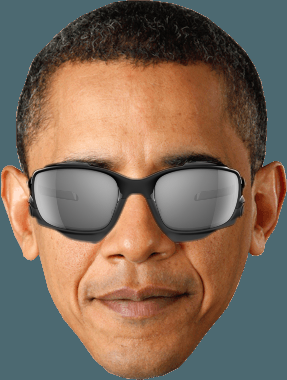

In [ ]:
glass_list=["/content/gdrive/My Drive/Advanced Machine Learning/Project/glass_2.png",
            "/content/gdrive/My Drive/Advanced Machine Learning/Project/glass_1.png",
            "/content/gdrive/My Drive/Advanced Machine Learning/Project/glass_3.png",
            "/content/gdrive/My Drive/Advanced Machine Learning/Project/glass_4.png"] # list of sunglasses
#print(glass_list)
img = cv2.imread("/content/gdrive/My Drive/Advanced Machine Learning/Project/face_1.png")

face = detector(img, 1) # detecting face in the image, note--> if face.jpg has multiple faces it will detect all and apply the filter to each of the faces in the image


for face in face: # irerating over each face in the image (face.jpg) 
  landmarks = predictor(img, face) # predicting landmarks for the detected face, in this case only one
  result_2 = add_glasses(img, landmarks= landmarks, glasses_list= glass_list) # adding filter
  cv2_imshow(result_2)  

#Add Mask

In [ ]:
def add_mask(face_img, landmarks, mask_list):
      overlay_t_img  = cv2.imread(random.choice(mask_list), -1) # randomly selecting a mask image with transparent background  

      # Face co-ordinate  
      face_left = (landmarks.part(4).x, landmarks.part(4).y)  
      face_right = (landmarks.part(14).x, landmarks.part(14).y)  
      face_bottom = (landmarks.part(8).x, landmarks.part(8).y)
      lip_center = (landmarks.part(51).x, landmarks.part(51).y)
      
      mask_top = (landmarks.part(29).x, landmarks.part(29).y)
      mask_width = int(hypot(face_left[0] - face_right[0], face_left[1] - face_right[1]))
      mask_height = int((hypot(mask_top[0] - face_bottom[0], mask_top[1] - face_bottom[1] )))  
      roi_top_left =  (abs(int(lip_center[0] - mask_width/2)), abs(int(lip_center[1] - mask_height/2)))
      roi_bottom_right = (abs(int(lip_center[0] + mask_width/2)), abs(int(lip_center[1] + mask_height/2)))
      roi =  face_img[roi_top_left[1]: roi_top_left[1] + mask_height, roi_top_left[0]: roi_top_left[0]+mask_width]       
      overlay_t_img = cv2.resize(overlay_t_img, (roi.shape[1], roi.shape[0]))          
      # Split out the transparency mask from the colour info
      overlay_mask = overlay_t_img[: , : , 3:]  # Grab the alpha plane  
      overlay_img = overlay_t_img[: , : , :3] # Grab the BRG planes
      # Let's shrink and blur it a little to make the transitions smoother...
      overlay_mask = cv2.erode(overlay_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
      overlay_mask = cv2.blur(overlay_mask, (3, 3))          
      # Again calculate the inverse mask
      background_mask = 255 - overlay_mask            
      # Turn the masks into three channel, so we can use them as weights
      overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
      background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)        
      # Create a masked out face image, and masked out overlay
      # We convert the images to floating point in range 0.0 - 1.0
      face_part = face_part = (roi  * (background_mask * (1 / 255.0)))
      overlay_part = (overlay_img * (overlay_mask * (1 / 255.0)))    
      dst = cv2.add(face_part,overlay_part)
      face_img[roi_top_left[1]: roi_top_left[1] + mask_height, roi_top_left[0]: roi_top_left[0]+mask_width] = dst          
      return face_img
    # ==============================================================================

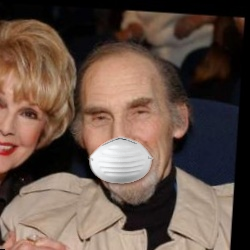

In [ ]:
mask_list=["/content/gdrive/My Drive/Advanced Machine Learning/Project/mask_1.png",
           "/content/gdrive/My Drive/Advanced Machine Learning/Project/mask_2.png",
           "/content/gdrive/My Drive/Advanced Machine Learning/Project/mask_3.png"] # list of masks
img = cv2.imread("/content/gdrive/My Drive/Advanced Machine Learning/Project/lfw_funneled/Sid_Caesar/Sid_Caesar_0001.jpg")

face = detector(img, 1)

for face in face:
  landmarks = predictor(img, face)
  result_4 = add_mask(img, landmarks= landmarks, mask_list= mask_list)
  cv2_imshow(result_4)

In [ ]:
prefix = "/content/gdrive/My Drive/Advanced Machine Learning/Project/lfw_funneled"
faces = list()
count_mask = 0
count_glass = 0
count = 0

for subdir in os.listdir(prefix):
  file_path = prefix + '/' + subdir + '/'
  _file_name = random.choice(os.listdir(file_path))
  file_name = file_path + _file_name

  img_selected = cv2.imread(file_name)
  face = detector(img_selected, 1)

  for face in face:
    decision = random.randint(0,1)
    landmarks = predictor(img_selected, face)
    if decision == 0:
      new_image = add_glasses(img_selected, landmarks= landmarks, glasses_list= glass_list)
      count_glass = count_glass + 1
      #cv2_imshow(new_image)
    else:
       new_image = add_mask(img_selected, landmarks=landmarks, mask_list=mask_list)
       count_mask = count_mask + 1
       #cv2_imshow(new_image)
       
    os.makedirs('/content/gdrive/My Drive/Advanced Machine Learning/Project/balvansh_test/'+subdir, exist_ok=True)
    result = cv2.imwrite(r'/content/gdrive/My Drive/Advanced Machine Learning/Project/balvansh_test/'+subdir+'/'+_file_name, new_image)

    if result == True:
      print("Image No %d --- File Name: %s " %(count_mask + count_glass, _file_name))
    else:
      print("Failure")

  print("Done")

print("Number of images with glasses: %d \nNumber of images with masks: %d" %(count_glass, count_mask))

Streaming output truncated to the last 5000 lines.
Image No 3425 --- File Name: Abdul_Majeed_Shobokshi_0001.jpg 
Done
Image No 3426 --- File Name: Rudy_Tomjanovich_0001.jpg 
Done
Image No 3427 --- File Name: Peter_Harrison_0002.jpg 
Done
Image No 3428 --- File Name: Kathleen_Kennedy_Townsend_0003.jpg 
Done
Image No 3429 --- File Name: Pilar_Montenegro_0001.jpg 
Done
Image No 3430 --- File Name: Dusty_Baker_0001.jpg 
Done
Done
Image No 3431 --- File Name: Dan_Wheldon_0002.jpg 
Done
Image No 3432 --- File Name: Felicity_Huffman_0001.jpg 
Done
Image No 3433 --- File Name: Gloria_Trevi_0003.jpg 
Done
Image No 3434 --- File Name: Marc_Shaiman_0001.jpg 
Done
Image No 3435 --- File Name: Robert_Douglas_0001.jpg 
Done
Image No 3436 --- File Name: Pete_Beaudrault_0001.jpg 
Done
Image No 3437 --- File Name: Ken_Macha_0002.jpg 
Done
Image No 3438 --- File Name: Beth_Jones_0001.jpg 
Done
Image No 3439 --- File Name: Carey_Lowell_0001.jpg 
Done
Image No 3440 --- File Name: James_McPherson_0001.jpg 